In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image, ImageOps
from torchvision import models, transforms

### Load model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()

print(model)

Using device: cuda
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Re

### Setup transforms and example image

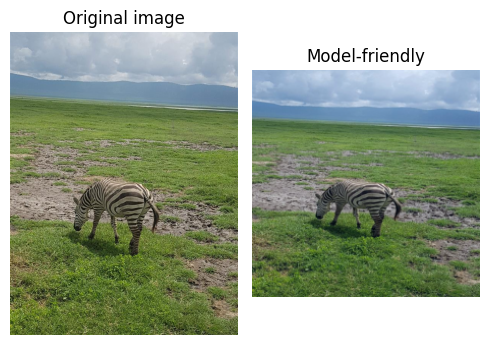

In [3]:
# Load your image here
image_path = "../data/zebra_jacob.jpg"
image = Image.open(image_path)
image = ImageOps.exif_transpose(image) # Potentially flip image if it was taken in portrait mode

transform_human = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# For model input: resize, divides by 255, then normalize with ImageNet statistics
transform_model = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
image_human = transform_human(image)
image_model = transform_model(image)

# Min-max normalize to [0,1]. Do not give this to the model! Just for plotting
image_model_normalized = (image_model - image_model.min()) / (image_model.max() - image_model.min())

fig, axs = plt.subplots(1, 2, figsize=(5, 8))
axs[0].imshow(image)
axs[0].axis("off")
axs[0].set_title("Original image")
axs[1].imshow(image_model_normalized.permute(1, 2, 0))
axs[1].axis("off")
axs[1].set_title("Model-friendly")
plt.tight_layout()
plt.show()

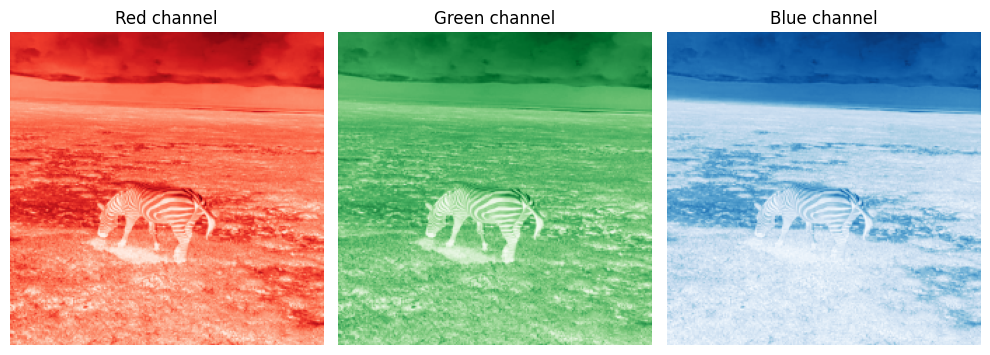

In [4]:
# Plot RGB channels of image_model
Colors = {"Red": "Reds", "Green": "Greens", "Blue": "Blues"}
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for i, channel in enumerate(("Red", "Green", "Blue")):
    axs[i].imshow(image_model[i], cmap=Colors[channel])
    axs[i].axis("off")
    axs[i].set_title(f"{channel} channel")
plt.tight_layout()
plt.show()

### First convolutional layer

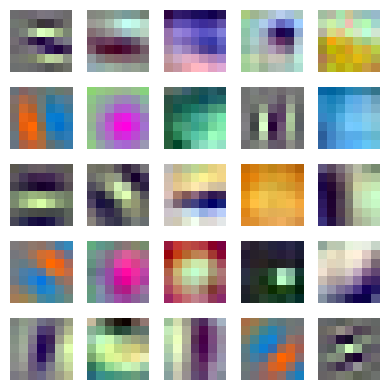

In [5]:
fig, axs = plt.subplots(5, 5, figsize=(4, 4))
for i, ax in enumerate(axs.flat):
    weights = model.conv1.weight[i].cpu().detach().numpy().transpose(1, 2, 0)
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    ax.imshow(weights)
    ax.axis("off")
plt.tight_layout()
plt.show()

### Horizontal line detector (Gabor filter)

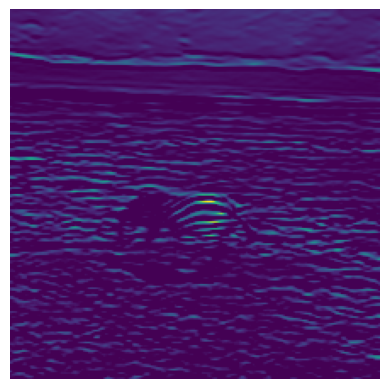

In [6]:
# Extract filter #11 (first in third row)
filter_weights = model.conv1.weight[10].cpu().detach().unsqueeze(0) # shape: (1, 3, 7, 7)

# Add batch dimension to the image: (1, 3, 224, 224)
image_batch = image_model.unsqueeze(0)

# Apply convolution and ReLU
filtered_image = F.relu(F.conv2d(image_batch, filter_weights))
filtered_image = filtered_image.squeeze(0).squeeze(0)

plt.imshow(filtered_image)
plt.axis("off")
plt.show()

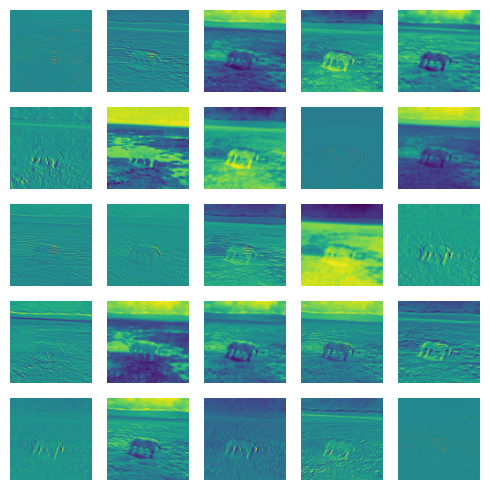

In [7]:
# Apply first 25 filters
weights = model.conv1.weight[:25].cpu().detach() # (25, 3, 7, 7)
feature_maps = F.conv2d(image_batch, weights).squeeze(0) # (25, H', W')

# Plot feature maps
fig, axs = plt.subplots(5, 5, figsize=(5, 5))
for i, ax in enumerate(axs.flat):
    feature_map = feature_maps[i].cpu().detach().numpy()
    ax.imshow(feature_map)
    ax.axis("off")
plt.tight_layout()
plt.show()

### Later layers are not interpretable

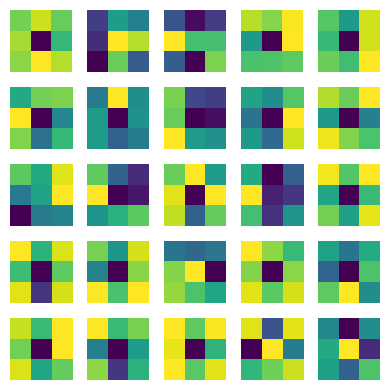

In [8]:
fig, axs = plt.subplots(5, 5, figsize=(4, 4))
for i, ax in enumerate(axs.flat):
    # Extract the filters in the second convolutional layer
    weights = model.layer1[0].conv1.weight[i].cpu().detach().numpy()
    weights = weights.mean(axis=0) # (64x3x3) -> (3x3)
    weights = (weights - weights.min()) / (weights.max() - weights.min())
    
    ax.imshow(weights, cmap='viridis')
    ax.axis("off")
plt.tight_layout()
plt.show()

### Visualize feature maps in later layers

In [9]:
output_feature_maps = {}
def forward_hook(module, input, output):
    output_feature_maps[module] = output

# Add hooks to conv layers
hooks = []
for layer in model.modules():
    if isinstance(layer, torch.nn.Conv2d): # Ignoring BatchNorm, Pooling, FC layer, ReLU
        hooks.append(layer.register_forward_hook(forward_hook))

# Forward the image to collect feature maps
with torch.no_grad():
    output = model(image_batch.to(device))

for hook in hooks:
    hook.remove()

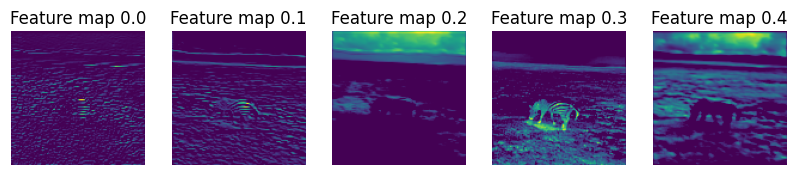

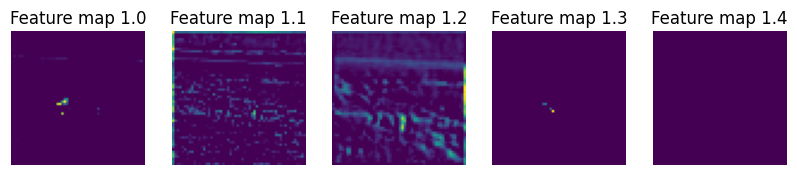

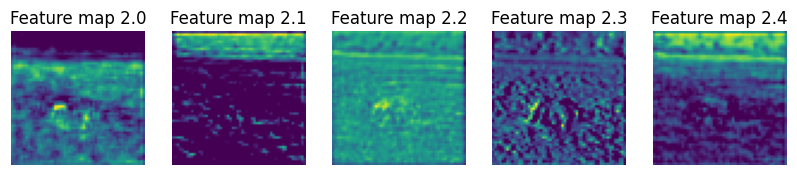

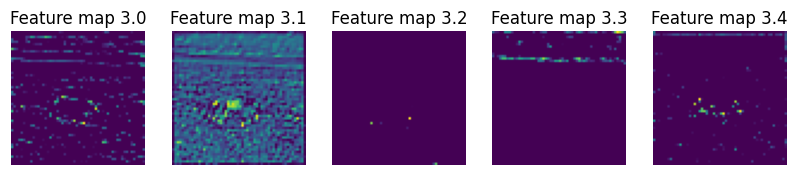

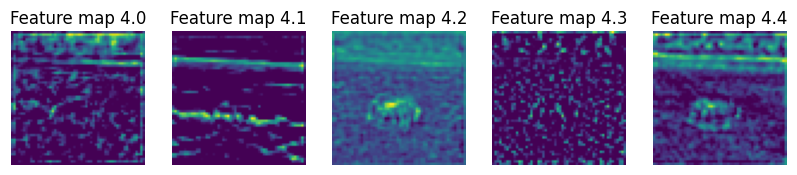

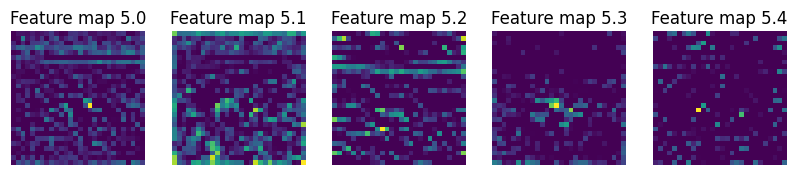

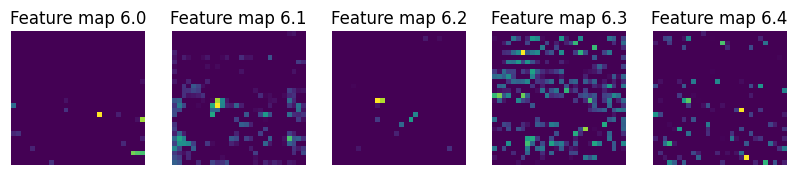

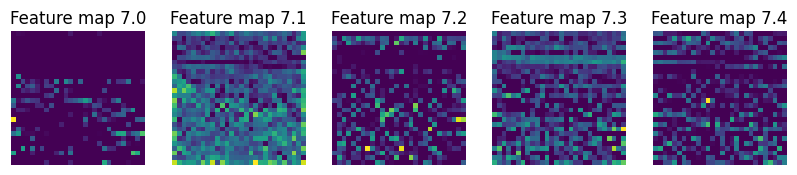

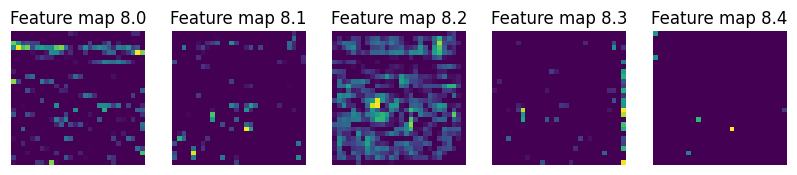

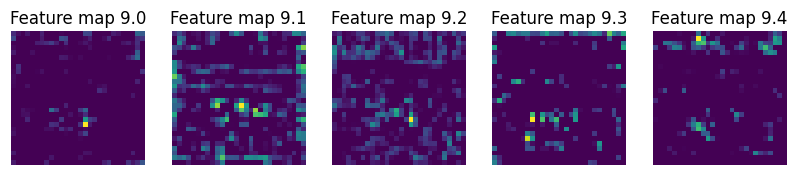

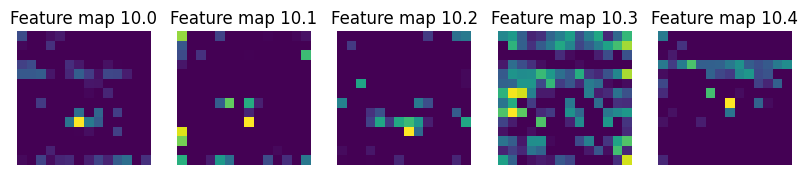

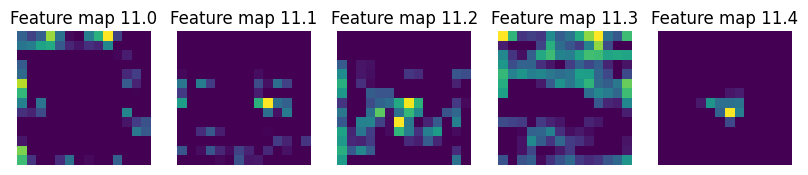

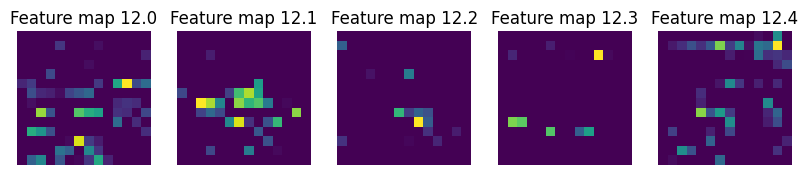

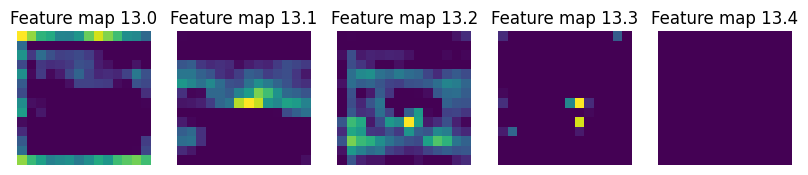

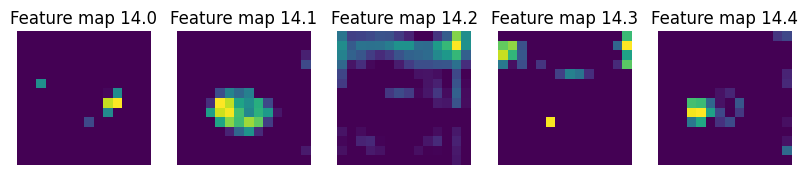

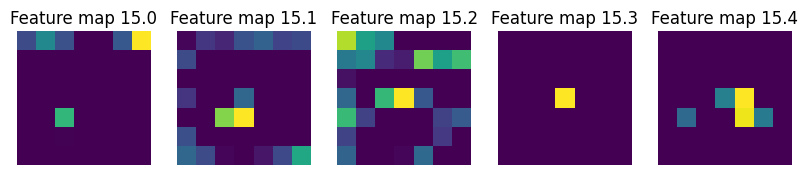

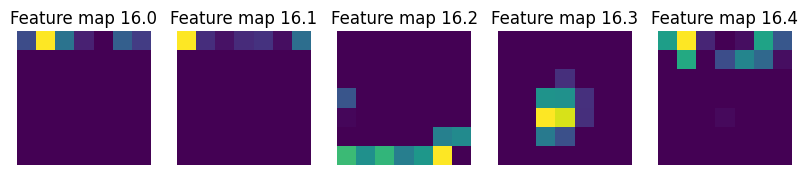

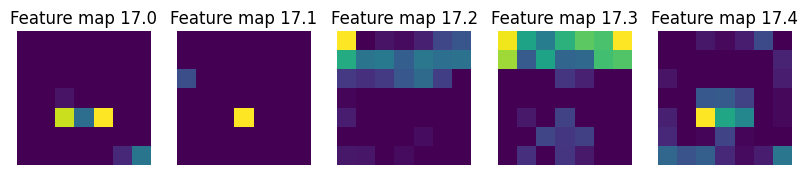

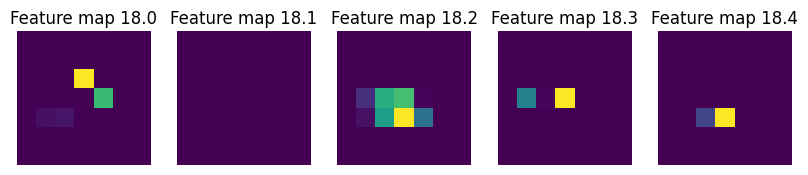

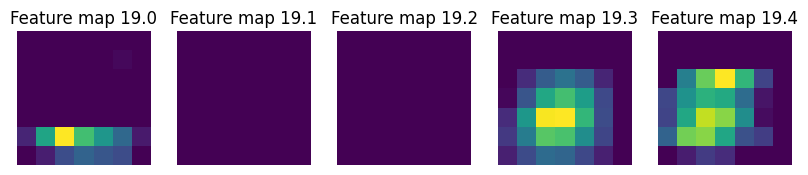

In [10]:
# Plot 5 feature maps for each layer
for i, (layer, feature_map) in enumerate(output_feature_maps.items()):
    fig, axs = plt.subplots(1, 5, figsize=(10, 5))
    for j in range(5):
        feature_map_j = F.relu(feature_map[0][j]).squeeze().cpu().detach().numpy()
        axs[j].imshow(feature_map_j)
        axs[j].axis("off")
        axs[j].set_title(f"Feature map {i}.{j}")
    plt.show()

### Filter 14.1 looks interesting, maybe it is zebra-related?

### OPTIONAL: Download Broden dataset from https://github.com/CSAILVision/NetDissect
Only do this if you're on a computer with 1-2 GB to spare!

1. git clone https://github.com/CSAILVision/NetDissect.git
2. cd NetDissect
3. script/dlbroden_227.sh

In [11]:
# Add hook to target layer
outputs = []
def forward_hook(module, input, output):
    outputs.append(output)

conv_idx = 14
filter_idx = 1
# option 1: reference target layer by index
#hook = list(output_feature_maps.keys())[conv_idx].register_forward_hook(forward_hook)
# option 2: reference target layer by name
hook = model.layer3[1].conv2.register_forward_hook(forward_hook)

# Folder to load N images from.
valid_formats = {".jpg", ".jpeg", ".png"}
N = 500
# Decide which dataset to use. Different datasets give different results!
images_dir = "../data/broden/pascal"
ignore_types = ("color", "object", "part") # Ignore segmentation maps in Broden
files = [f for f in os.listdir(images_dir) if os.path.splitext(f)[1].lower() in valid_formats and not any(ignore_type in f for ignore_type in ignore_types)]
images = torch.stack([transform_model(Image.open(os.path.join(images_dir, f))) for f in files[:N]]).to(device)

# Forward images, collect outputs and remove hook
outputs = []
with torch.no_grad():
    model(images)
hook.remove()

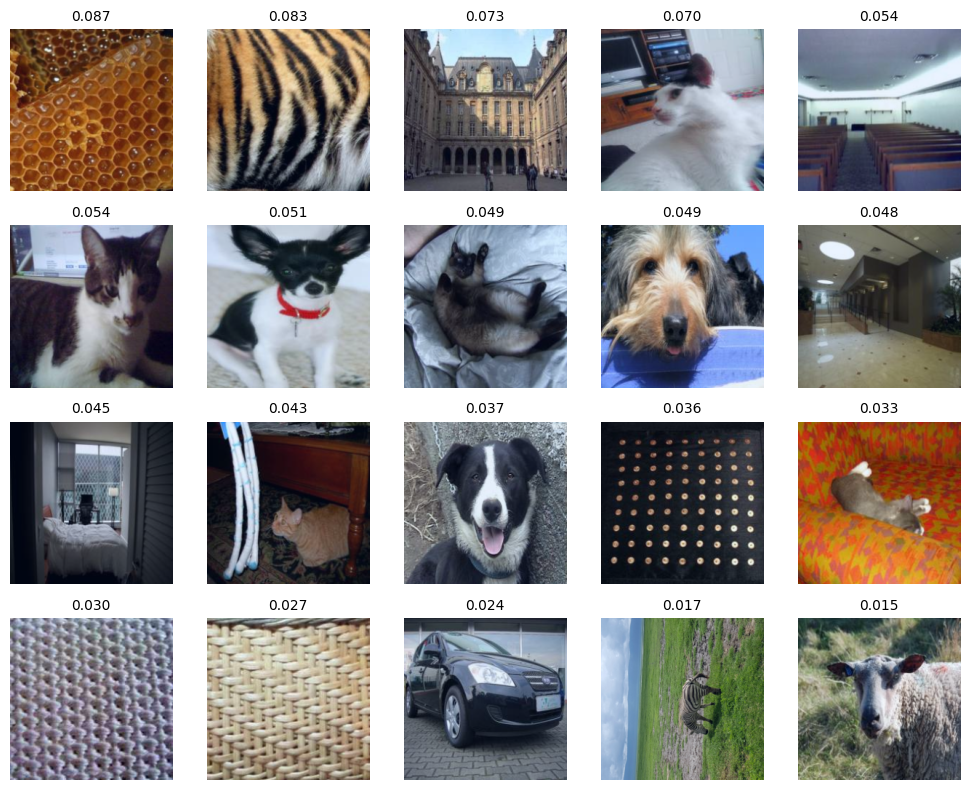

In [12]:
# Get feature maps of the target filter
feature_maps = outputs[0][:, filter_idx, :, :]
# Apply ReLU
feature_maps = F.relu(feature_maps)
# Aggregate to single score per image
scores = feature_maps.mean(dim=(1, 2))
# Sort images by the score: Mean activation of a feature map (post-ReLU)
sorted_indices = torch.argsort(scores, descending=True)

# Determine number of images to plot
cols = 5
rows = 4
num_images = min(cols*rows, len(images))
fig, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))
# Plot most activating images
for i, ax in enumerate(axs.flat):
    if i >= num_images:
        ax.axis("off")
        continue

    image = images[sorted_indices[i]].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image.cpu().numpy())

    score_value = scores[sorted_indices[i]].detach().cpu().item()
    ax.set_title(f"{score_value:.3f}", fontsize=10)
    ax.axis("off")
plt.tight_layout()
plt.show()

### Activation maximization

Iteration 0, score: 0.004
Iteration 50, score: 0.610
Iteration 100, score: 1.051
Iteration 150, score: 1.194
Iteration 200, score: 1.231
Iteration 250, score: 1.241
Iteration 300, score: 1.252
Iteration 350, score: 1.271
Iteration 400, score: 1.284
Iteration 450, score: 1.294


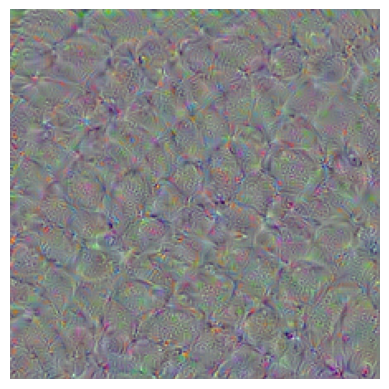

In [13]:
# We optimize this X such that the activation "score" is maximized
X = torch.randn(1, 3, 224, 224).to(device)
X.requires_grad = True

# Add hook to target layer
hook = list(output_feature_maps.keys())[conv_idx].register_forward_hook(forward_hook)

iterations = 500
optimizer = torch.optim.Adam([X], lr=0.01)
for i in range(iterations):
    # Forward pass
    outputs.clear()
    _ = model(X)
    # Calculate score
    score = outputs[0][0, filter_idx, :, :]
    score = F.relu(score).mean()
    # Calculate loss
    loss = -score
    reg_loss = 0.01 * torch.norm(X, p=2) # L2 regularization
    loss = loss + reg_loss
    # Backward gradients and update X
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if i % 50 == 0:
        print(f"Iteration {i}, score: {score.mean().item():.3f}")
hook.remove()

# Plot the generated image
generated_image = X.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
generated_image = (generated_image - generated_image.min()) / (generated_image.max() - generated_image.min())
plt.imshow(generated_image)
plt.axis("off")
plt.show()

100%|██████████| 512/512 [00:04<00:00, 124.81it/s]


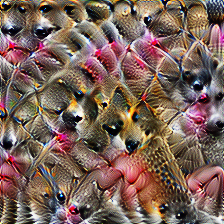

In [14]:
# !pip install torch-lucent

# Activation maximization with lucent
import lucent.optvis.objectives as objectives
import lucent.optvis.param as param
import lucent.optvis.render as render

size = 224
objective = objectives.channel(layer="layer3_1_conv2", n_channel=filter_idx) # Must reference layer by name
param_f = lambda: param.image(size)

_ = render.render_vis(model.to(device), objective, param_f=param_f, thresholds=(512,), fixed_image_size=(size, size), show_image=True)[0]